In [ ]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz, filtfilt
from pywt import swt, cwt
import scipy.misc
from scipy.signal import welch
import tensorflow as tf
import keras
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, AvgPool2D, Reshape, BatchNormalization, Bidirectional, LSTM
from keras.layers import Activation, GlobalMaxPool2D, SpatialDropout2D, GlobalAvgPool2D, SeparableConv1D
from keras.layers import AvgPool1D, Conv1D, GlobalMaxPool1D, MaxPool1D, SpatialDropout1D, GlobalAvgPool1D, Add, Concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler                                                      
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from scipy import signal
import pickle as pkl
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


59

In [ ]:
input_path='/content/drive/MyDrive/DREAMER_csv/'

In [ ]:
sampling_rate = 128
window_size = 384
channel_len = 14
classes = 2

bands = {'delta': [0.5/(sampling_rate/2), 4/(sampling_rate/2)], 'theta': [4/(sampling_rate/2), 8/(sampling_rate/2)], \
         'alpha': [8/(sampling_rate/2), 14/(sampling_rate/2)], 'beta': [14/(sampling_rate/2), 30/(sampling_rate/2)], \
         'gamma': [30/(sampling_rate/2), 50/(sampling_rate/2)]}

In [ ]:
int(7808/128)

61

In [ ]:
def baseline_remove(XS, XB):
  T1 = int(XB.shape[0]/128) # Fs = 128 Hz
  T2 = int(XS.shape[0]/128)
  XB_ = 0
  for i in range(T1):
    XB_ += XB[i*128:(i+1)*128, :]
  XB_ /= T1
  for i in range(T2):
    XS[i*128:(i+1)*128, :] -= XB_
  return XS

In [ ]:
data = []
val_label = []
aro_label = []
dom_label = []

for person in range(1,2):
  print('Person No.' + str(person))
  
  # EEG files address
  address = input_path+'s'+str(person)
    

  # Loading Valence Label
  valence = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_val.csv' , header = None)
  valence = valence.values.ravel()

  # Loading Arousal Label
  arousal = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_aro.csv' , header = None)
  arousal = arousal.values.ravel()

  # Dominance values
  dominance = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_dom.csv' , header = None)
  dominance = dominance.values.ravel()
  
  # Assigning classes
  valence[valence<=3]=0
  valence[valence>3]=1  
  arousal[arousal<=3]=0
  arousal[arousal>3]=1
  dominance[dominance<=3]=0
  dominance[dominance>3]=1

  # Preprocessing
  for i in range(1,19):
    eeg_stimuli = pd.read_csv(address+'/s'+str(person)+'_v'+str(i)+'.csv', header=None)
    eeg_baseline = pd.read_csv(input_path+'Baseline''/s'+str(person)+'_v'+str(i)+'_base'+'.csv', header=None)
    eeg_stimuli = eeg_stimuli.values
    eeg_baseline = eeg_baseline.values
    eeg = baseline_remove(eeg_stimuli, eeg_baseline)
    
    # Segmenting into 3 seconds (384 timesteps) windows without overlapping
    start = 0
    while start+window_size < eeg.shape[0]:
      data.append(eeg[start:start+window_size,:].T)
      val_label.append(valence[i-1])
      aro_label.append(arousal[i-1])
      dom_label.append(dominance[i-1])
      start = start+window_size
    del eeg

  data = np.array(data, dtype = np.float32) # Using 32 bit floating point value to save memory
  val_label = np.array(val_label, dtype = np.int8)
  aro_label = np.array(aro_label, dtype = np.int8)
  dom_label = np.array(dom_label, dtype = np.int8)

  print(data.shape)
  print(val_label.shape, val_label[val_label == 0].shape, val_label[val_label == 1].shape)
  print(aro_label.shape, aro_label[aro_label == 0].shape, aro_label[aro_label == 1].shape)
  print(dom_label.shape, dom_label[dom_label == 0].shape, dom_label[dom_label == 1].shape)

  valence = np_utils.to_categorical(val_label)
  arousal = np_utils.to_categorical(aro_label)
  dominance = np_utils.to_categorical(dom_label)      
  del val_label, aro_label, dom_label


Person No.1
(1232, 14, 384)
(1232,) (653,) (579,)
(1232,) (846,) (386,)
(1232,) (485,) (747,)


# **Proposed Architecture**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def simple_2D_CNN(x):
  '''x = Bidirectional(LSTM(64, return_sequences=True))(x)
  x = Dropout(0.1)(x)'''
  '''x = Bidirectional(LSTM(16, return_sequences=True))(x)'''
  #x = Reshape((x.shape[1], x.shape[2],1))(x)
  x = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(1,2))(x)
  
  x = Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=(1,2))(x)

  x = Conv2D(filters = 32, kernel_size = 7, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)
  '''
  x1 = Flatten()(x[:,:,0,:])
  x2 = Flatten()(x[:,:,1,:])
  x2 = Concatenate()([x1, x2])

  for i in range(2, x.shape[2]):
    x1 = Flatten()(x[:,:,i,:])
    x2 = Concatenate()([x1, x2])

  x = Reshape((x.shape[3], x.shape[2]))(x2)
  #x = Reshape((x.shape[3], 256))(x2)
  x = Dropout(0.1)(x)

  x = Bidirectional(LSTM(32, return_sequences=True))(x)
  x = Dropout(0.1)(x)
  x = Bidirectional(LSTM(16, return_sequences=True))(x)
  x = Dropout(0.1)(x)'''

  x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)

  '''x = Conv2D(filters = 64, kernel_size = 2, strides = 1, padding = 'same', activation='selu')(x)
  #x = BatchNormalization()(x)
  x = MaxPool2D(pool_size=2)(x)'''

  x = Dropout(0.1)(x)

  x = Flatten()(x)
  x = Dense(512, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(256, activation='elu')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model() :
  input_shape = (data.shape[1], data.shape[2], 1)
  a = Input(input_shape)
  out = simple_2D_CNN(a)
  model = Model(a, out)
  opt = keras.optimizers.Adam(learning_rate=1e-04)
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt)
  return model

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 384, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 14, 384, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 192, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 192, 32)       12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 96, 32)        50208 

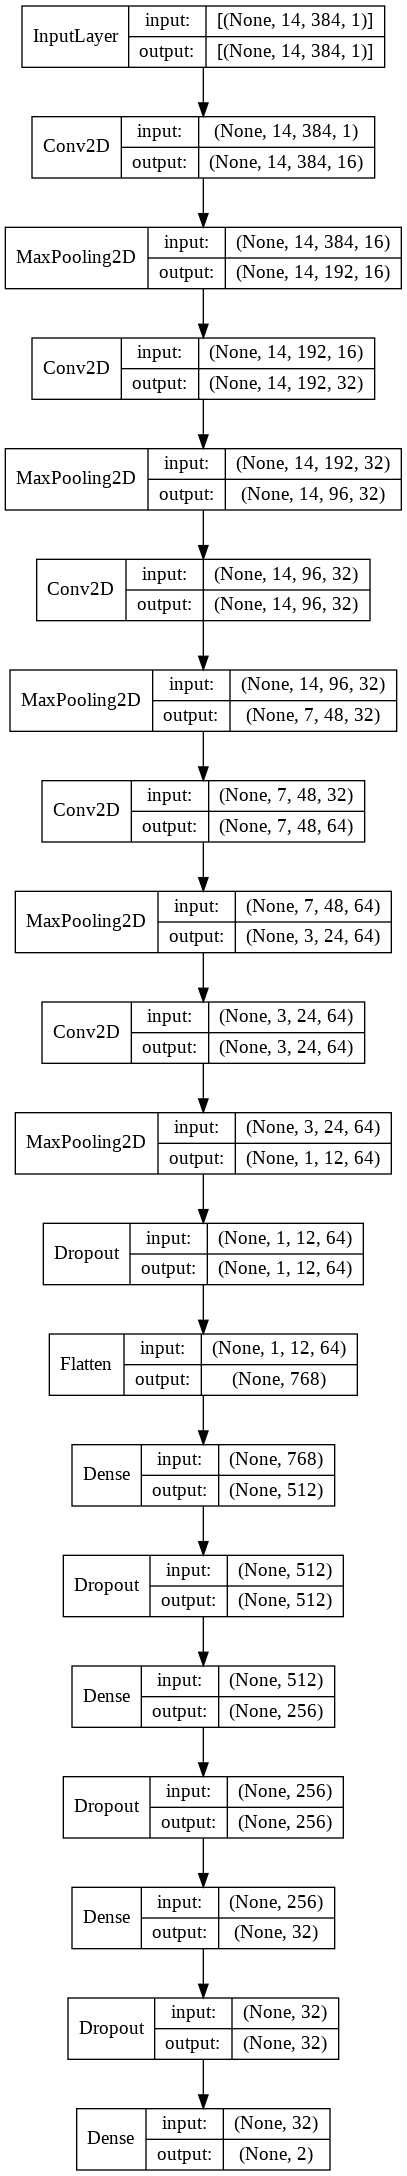

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
batch_size = 64
epochs = 50
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

3403

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.05, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1170, 14, 384) (62, 14, 384) (1170, 2) (62, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/50
17/17 [==============================] - 5s 253ms/step - loss: 0.8119 - accuracy: 0.4729 - val_loss: 0.6789 - val_accuracy: 0.6923
Epoch 2/50
17/17 [==============================] - 4s 237ms/step - loss: 0.6981 - accuracy: 0.5271 - val_loss: 0.6773 - val_accuracy: 0.5470
Epoch 3/50
17/17 [==============================] - 4s 238ms/step - loss: 0.6697 - accuracy: 0.5774 - val_loss: 0.6425 - val_accuracy: 0.6410
Epoch 4/50
17/17 [==============================] - 4s 241ms/step - loss: 0.6327 - accuracy: 0.6543 - val_loss: 0.6482 - val_accuracy: 0.6068
Epoch 5/50
17/17 [==============================] - 4s 248ms/step - loss: 0.5996 - accuracy: 0.6619 - val_loss: 0.5281 - val_accuracy: 0.8034
Epoch 6/50
17/17 [==============================] - 4s 243ms/step - loss: 0.5449 - accuracy: 0.7198 - val_loss: 0.4439 - val_accuracy: 0.8205
Epoch 7/50
17/17 [==============================] - 4s 248ms/step - loss: 0.4832 - accuracy: 0.7607 - val_loss: 0.4204 - val_accu

Accuracy  : 0.9032258033752442
F1_Score  : 0.9025332897227916


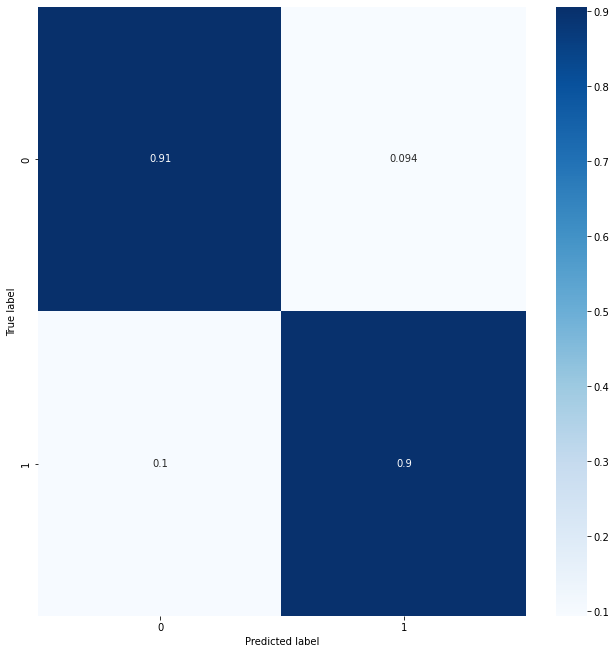

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
for i in val_res['accuracy']:
  print(round(i[1]*100, 2)) # Rounding off to two decimal places
for i in val_res['confusion_matrix']:
  print(i)

56.5
61.02
54.8
48.59
68.93
53.67
61.58
94.35
70.62
49.15
[[25 70]
 [ 7 75]]
[[32 58]
 [11 76]]
[[20 76]
 [ 4 77]]
[[ 9 81]
 [10 77]]
[[58 43]
 [12 64]]
[[ 4 82]
 [ 0 91]]
[[91  8]
 [60 18]]
[[99  0]
 [10 68]]
[[47 41]
 [11 78]]
[[12 83]
 [ 7 75]]


# ***Arousal***

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, arousal, test_size=0.05, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(1170, 14, 384) (62, 14, 384) (1170, 2) (62, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/50
17/17 [==============================] - 5s 248ms/step - loss: 0.8106 - accuracy: 0.5223 - val_loss: 0.7126 - val_accuracy: 0.4786
Epoch 2/50
17/17 [==============================] - 4s 239ms/step - loss: 0.6833 - accuracy: 0.5290 - val_loss: 0.6598 - val_accuracy: 0.5983
Epoch 3/50
17/17 [==============================] - 4s 231ms/step - loss: 0.6691 - accuracy: 0.5973 - val_loss: 0.6326 - val_accuracy: 0.6154
Epoch 4/50
17/17 [==============================] - 4s 235ms/step - loss: 0.6298 - accuracy: 0.6429 - val_loss: 0.6417 - val_accuracy: 0.5897
Epoch 5/50
17/17 [==============================] - 4s 233ms/step - loss: 0.5953 - accuracy: 0.6752 - val_loss: 0.6803 - val_accuracy: 0.6154
Epoch 6/50
17/17 [==============================] - 4s 231ms/step - loss: 0.5527 - accuracy: 0.7028 - val_loss: 0.5086 - val_accuracy: 0.6923
Epoch 7/50
17/17 [==============================] - 4s 236ms/step - loss: 0.5006 - accuracy: 0.7445 - val_loss: 0.4606 - val_accu

Accuracy  : 0.8387096643447876
F1_Score  : 0.8039988096393091


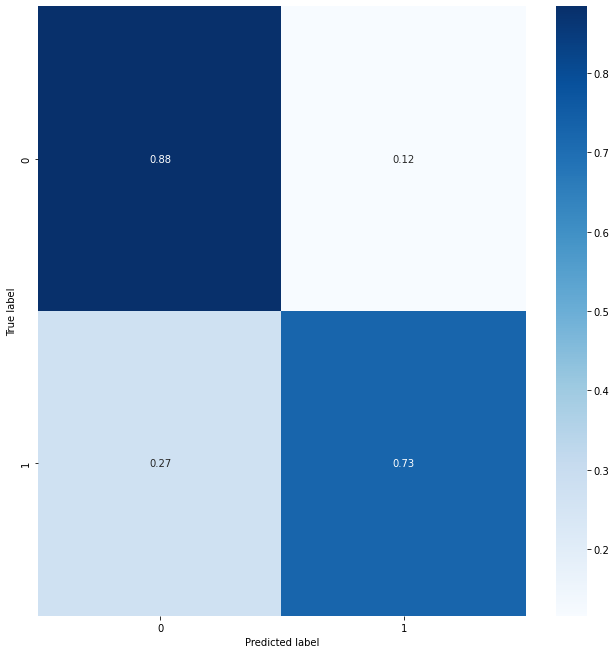

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
aro_res = {'accuracy': [], 'confusion_matrix': []}

for i in range(FOLD):
  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  aro_train = np.concatenate((arousal[0 : i*factor], arousal[(i+1)*factor : nb_samples])) # Arousal training labels
  aro_test = arousal[i*factor : (i+1)*factor] # Arousal testing labels

  model = get_model()
  model.fit(X_train, aro_train, epochs = 100, batch_size = 1024, shuffle = True)

  acc = model.evaluate(X_test, aro_test)
  print(acc)
    
  aro_res['accuracy'].append(acc)

  pred = model.predict(X_test)
  aro_res['confusion_matrix'].append(confusion_matrix(aro_test.argmax(1), pred.argmax(1)))


# Dumping arousal results
file = './eeg_data/Dreamer_arousal_' + eeg_band + '.pkl'

with open(file, 'wb') as f:
  pkl.dump(aro_res, f)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0  

In [ ]:
for i in aro_res['accuracy']:
  print(round(i[1]*100, 2)) # Rounding off to two decimal places
for i in aro_res['confusion_matrix']:
  print(i)

# **Dominance**

In [ ]:
dom_res = {'accuracy': [], 'confusion_matrix': []}

for i in range(FOLD):
  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  dom_train = np.concatenate((dominance[0 : i*factor], dominance[(i+1)*factor : nb_samples])) # Dominance training labels
  dom_test = dominance[i*factor : (i+1)*factor] # Dominance testing labels

  model = get_model()
  model.fit(X_train, dom_train, epochs = 100, batch_size = 1024, shuffle = True)

  acc = model.evaluate(X_test, dom_test)
  print(acc)
    
  dom_res['accuracy'].append(acc)

  pred = model.predict(X_test)
  dom_res['confusion_matrix'].append(confusion_matrix(dom_test.argmax(1), pred.argmax(1)))


# Dumping dominance results
file = './eeg_data/Dreamer_dominance_' + eeg_band + '.pkl'

with open(file, 'wb') as f:
  pkl.dump(dom_res, f)

Results for fold 1
Epoch 1/30
14/14 [==============================] - 2s 63ms/step - loss: 1.1227 - accuracy: 0.4773 - val_loss: 1.0108 - val_accuracy: 0.5556
Epoch 2/30
14/14 [==============================] - 1s 43ms/step - loss: 1.0209 - accuracy: 0.5333 - val_loss: 0.9734 - val_accuracy: 0.5661
Epoch 3/30
14/14 [==============================] - 1s 43ms/step - loss: 1.0097 - accuracy: 0.5503 - val_loss: 0.9806 - val_accuracy: 0.5661
Epoch 4/30
14/14 [==============================] - 1s 44ms/step - loss: 1.0127 - accuracy: 0.5486 - val_loss: 0.9639 - val_accuracy: 0.5661
Epoch 5/30
14/14 [==============================] - 1s 44ms/step - loss: 1.0036 - accuracy: 0.5427 - val_loss: 0.9817 - val_accuracy: 0.5661
Epoch 6/30
14/14 [==============================] - 1s 43ms/step - loss: 1.0044 - accuracy: 0.5503 - val_loss: 0.9491 - val_accuracy: 0.5661
Epoch 7/30
14/14 [==============================] - 1s 44ms/step - loss: 1.0021 - accuracy: 0.5468 - val_loss: 0.9419 - val_accuracy: 0

15/15 [==============================] - 0s 7ms/step - loss: 0.6720 - accuracy: 0.8835
Accuracy  : 0.883474588394165
F1_Score  : 0.8674658275784227


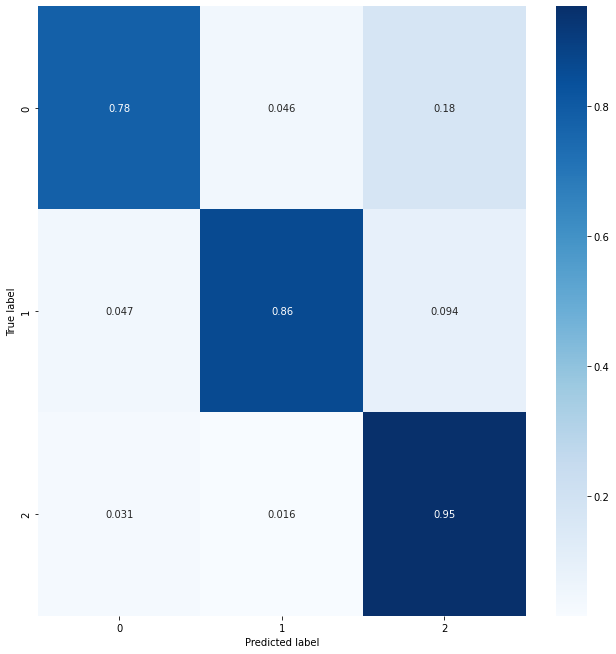

In [ ]:
for i in dom_res['accuracy']:
  print(round(i[1]*100, 2)) # Rounding off to two decimal places
for i in dom_res['confusion_matrix']:
  print(i)

In [ ]:
data = []
val_label = []
aro_label = []
dom_label = []

for person in range(1,2):
  print('Person No.' + str(person))
  
  # EEG files address
  address = input_path+'s'+str(person)
    

  # Loading Valence Label
  valence = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_val.csv' , header = None)
  valence = valence.values.ravel()

  # Loading Arousal Label
  arousal = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_aro.csv' , header = None)
  arousal = arousal.values.ravel()

  # Dominance values
  dominance = pd.read_csv(address+ '/Label_1/'+ 's'+str(person)+'_dom.csv' , header = None)
  dominance = dominance.values.ravel()
  
  # Assigning classes
  valence[valence<=3]=0
  valence[valence>3]=1  
  arousal[arousal<=3]=0
  arousal[arousal>3]=1
  dominance[dominance<=3]=0
  dominance[dominance>3]=1

  # Preprocessing
  for i in range(1,19):
    eeg = pd.read_csv(address+'/s'+str(person)+'_v'+str(i)+'.csv', header=None)
    eeg = eeg.values

    num, den = signal.butter(4, bands['alpha'], 'bandpass') # Butterworth filter of order N = 4
    band_signal = signal.filtfilt(num, den, eeg, axis=0)
    eeg = band_signal
    del band_signal, num, den
    
    scaler = StandardScaler().fit(eeg)
    scaled_eeg = scaler.transform(eeg)
    del eeg
    
    # Segmenting into 10 seconds (1280 timesteps) windows with 2 seconds (256 timesteps) overlap
    start = 0
    while start+window_size < scaled_eeg.shape[0]:
      data.append(scaled_eeg[start:start+window_size,:])
      val_label.append(valence[i-1])
      aro_label.append(arousal[i-1])
      dom_label.append(dominance[i-1])
      start = start+overlap
    del scaled_eeg

  data = np.array(data, dtype = np.float32) # Using 32 bit floating point value to save memory
  val_label = np.array(val_label, dtype = np.int8)
  aro_label = np.array(aro_label, dtype = np.int8)
  dom_label = np.array(dom_label, dtype = np.int8)

  print(data.shape)
  print(val_label.shape, val_label[val_label == 0].shape, val_label[val_label == 1].shape)
  print(aro_label.shape, aro_label[aro_label == 0].shape, aro_label[aro_label == 1].shape)
  print(dom_label.shape, dom_label[dom_label == 0].shape, dom_label[dom_label == 1].shape)

  val_label = np_utils.to_categorical(val_label)
  aro_label = np_utils.to_categorical(aro_label)
  dom_label = np_utils.to_categorical(dom_label)      


Person No.1
(1777, 1280, 14)
(1777,) (944,) (833,)
(1777,) (1217,) (560,)
(1777,) (697,) (1080,)


In [ ]:
FOLD = 10 # Number of folds
 

nb_samples = data.shape[0] # Number of samples
factor = nb_samples//FOLD # Kth fold by this factor

shuffler = np.random.permutation(nb_samples) # Shuffling data

data = data[shuffler]
valence = val_label[shuffler]
arousal = aro_label[shuffler]
dominance = dom_label[shuffler]

In [ ]:
val_res = {'accuracy': [], 'confusion_matrix': []}

for i in range(FOLD):
  X_train = np.concatenate((data[0 : i*factor], data[(i+1)*factor : nb_samples])) # Training data
  X_test = data[i*factor : (i+1)*factor] # Testing data
  val_train = np.concatenate((valence[0 : i*factor], valence[(i+1)*factor : nb_samples])) # Valence training labels
  val_test = valence[i*factor : (i+1)*factor] # Valence testing labels

  model = get_model()
  model.fit(X_train, val_train, epochs = 100, batch_size = 1024, shuffle = True) 
  
  acc = model.evaluate(X_test, val_test)
  print(acc)

  val_res['accuracy'].append(acc)

  pred = model.predict(X_test)
  val_res['confusion_matrix'].append(confusion_matrix(val_test.argmax(1), pred.argmax(1)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eeg_input (InputLayer)      [(None, 1280, 14)]        0         
                                                                 
 conv1 (Conv1D)              (None, 638, 32)           2272      
                                                                 
 conv2 (Conv1D)              (None, 317, 32)           5152      
                                                                 
 avg_pool1 (AveragePooling1D  (None, 158, 32)          0         
 )                                                               
                                                                 
 batch_norm1 (BatchNormaliza  (None, 158, 32)          128       
 tion)                                                           
                                                                 
 spatial_dropout1 (SpatialDr  (None, 158, 32)          0   

In [ ]:
eeg_input = Input(shape = (window_size, channel_len), name='eeg_input') # Input layer

# CNN model
def get_CNN():
  x = Conv1D(filters = 32, kernel_size = 5, strides = 2, padding = 'valid', activation='relu', name='conv1')(eeg_input)
  x = Conv1D(filters = 32, kernel_size = 5, strides = 2, padding = 'valid', activation='relu', name='conv2')(x)
  x = AvgPool1D(pool_size=2, name='avg_pool1')(x)
  x = BatchNormalization(name='batch_norm1')(x)
  x = SpatialDropout1D(rate=0.125, name = 'spatial_dropout1')(x)
  x = Conv1D(filters = 64, kernel_size = 5, strides = 2, padding = 'valid', activation='relu', name='conv3')(x)
  x = Conv1D(filters = 64, kernel_size = 5, strides = 2, padding = 'valid', activation='relu', name='conv4')(x)
  x = AvgPool1D(pool_size=2, name='avg_pool2')(x)
  x = BatchNormalization(name='batch_norm2')(x)
  x = SpatialDropout1D(rate=0.25, name = 'spatial_dropout2')(x)
  x = Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = 'valid', activation='relu', name='conv5')(x)
  x = Conv1D(filters = 128, kernel_size = 3, strides = 1, padding = 'valid', activation='relu', name='conv6')(x)
  x = AvgPool1D(pool_size=2, name='avg_pool3')(x)
  x = BatchNormalization(name='batch_norm3')(x)
  x = SpatialDropout1D(rate=0.5, name = 'spatial_dropout3')(x)
  x = Conv1D(filters = 512, kernel_size = 3, strides = 1, padding = 'valid', activation='relu', name='conv7')(x)
  x = Conv1D(filters = 512, kernel_size = 3, strides = 1, padding = 'valid', activation='relu', name='conv8')(x)
  x = GlobalAvgPool1D(name='global_pool1')(x)
  x = BatchNormalization(name='batch_norm4')(x)
  x = Dropout(0.5)(x)
  x = Dense(64)(x)
  x = Activation('tanh')(x)
  x = Dense(8)(x)
  x = Activation('tanh')(x)
  x = Dropout(0.25, )(x)
  return x

def get_model():
  x = get_CNN()

  out = Dense(classes, activation='softmax', name = 'output')(x) # Output layer

  model = Model(inputs=eeg_input, outputs=out) # Creating a model instance
  
  adam = Adam(lr=1e-3,decay=1e-5) # Adam optimizer
  
  model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['categorical_accuracy']) # Compiling model
  model.summary()
  
  return model